# Comparison of modern neural network architectures for POS tagging for Spanish

POS tagging cannot be probably included in the list of the hottest NLP models. However, it is still quite an important task that is a must for undersanding a language structure and, therefore, improving the qualinty of language modeling, in general.\
Actually, there are multiple pretty good and excellent taggers for English. Meanwhile, what's up with other languages? Probably, not that cool:(
# Agenda:

Let's build some neural models for Spanish, check out and compare their quality!

Description of tools...\
Pytorch
Transformers
Metrics


These are some dependencies we'll need:

In [1]:
!pip install pytorch-crf

In [2]:
import spacy
import json
import nltk
import random
import numpy as np
import torch 
from nltk.tag import hmm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

SEED = 7

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## First of all, we should download and prepare our data

In [3]:
! git clone https://github.com/UniversalDependencies/UD_Spanish-AnCora
! mkdir ancora-json
! python -m spacy convert UD_Spanish-AnCora/es_ancora-ud-train.conllu ancora-json
! python -m spacy convert UD_Spanish-AnCora/es_ancora-ud-dev.conllu ancora-json
! python -m spacy convert UD_Spanish-AnCora/es_ancora-ud-test.conllu ancora-json

Cloning into 'UD_Spanish-AnCora'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 503 (delta 2), reused 5 (delta 1), pack-reused 495
Receiving objects: 100% (503/503), 108.34 MiB | 25.57 MiB/s, done.
Resolving deltas: 100% (349/349), done.
✔ Generated output file (14305 documents):
ancora-json/es_ancora-ud-train.json
✔ Generated output file (1654 documents):
ancora-json/es_ancora-ud-dev.json
✔ Generated output file (1721 documents):
ancora-json/es_ancora-ud-test.json


In [0]:
with open('/content/ancora-json/es_ancora-ud-train.json') as f:
  data_train = json.load(f)
  
with open('/content/ancora-json/es_ancora-ud-dev.json') as f:
  data_val = json.load(f)

with open('/content/ancora-json/es_ancora-ud-test.json') as f:
  data_test = json.load(f)

In [0]:
def create_dataset(data, test=False):
  tagged_sent = []
  if test is False:
    for j in range(len(data)):
      sentence = []
      for i in data[j]['paragraphs'][0]['sentences'][0]['tokens']:
        sentence.append((i['orth'], i['tag']))
      tagged_sent.append(sentence)
  else:
   for j in range(len(data)):
      sentence = []
      for i in data[j]['paragraphs'][0]['sentences'][0]['tokens']:
        sentence.append(i['orth'])
      tagged_sent.append(sentence)

  return tagged_sent

In [0]:
tagged_sent_train = create_dataset(data_train)
tagged_sent_val = create_dataset(data_val)
tagged_sent_test = create_dataset(data_test)

# Бейзлайн

Тэггер, возвращающий самый частый для каждого слова тэг - если слова не было в трейне - присваивает самый частотный тэг. Плохо работает с новыми данными

In [0]:
class MaxFreqTagger():

  def __init__(self):
    pass

  def __repr__(self):
    return 'An example of MaxFreqTagger\nAssigns each word the most frequent tag for it.'

  def fit(self, train_data):


    self.flat_list_items = [item for sublist in train_data for item in sublist]
    from collections import defaultdict, Counter
    
    tree = lambda: defaultdict(tree)
    dictionary = tree()

    for i,j in self.flat_list_items:
      if j not in dictionary[i].values():
        dictionary[i][j] =  1
      else:
        dictionary[i][j] +=  1
    self.max_tag_dict = {}

    for i, j in dictionary.items():
      for k in dictionary[i].keys():
        if dictionary[i][k] is max(dictionary[i].values()):
          self.max_tag_dict[i] = k 

    freq = Counter(self.max_tag_dict.values())
    self.most_common_tag = freq.most_common()[0][0]
    flat_tags = list(set([(word, tag)[1] for sentence in train_data for (word, tag) in sentence]))
    self.encoding = {j:i for i, j in enumerate(flat_tags)}

  def predict(self, test_data):

    self.prediction = []
    for sentence in test_data:
      sentence_pred = []
      for word, tag in sentence:
        try:
          pred = (word, self.max_tag_dict[word])
        except KeyError:
          pred = (word, self.most_common_tag)
        sentence_pred.append(pred) 
      self.prediction.append(sentence_pred)
    return self.prediction

  def predict_flat_encoded(self, test_data):
    flatted_words = [(word, tag)[0] for sentence in test_data for (word, tag) in sentence]
    flatted_tags = [(word, tag)[1] for sentence in test_data for (word, tag) in sentence]
    pred_tags = []
    for word in flatted_words:
        try:
          pred = self.max_tag_dict[word]
        except KeyError:
          pred = self.most_common_tag
        pred_tags.append(pred) 
    
    return [self.encoding[tag] for tag in flatted_tags], [self.encoding[tag] for tag in pred_tags]

  def eval(self, test_data):
    prediction = self.predict(test_data)
    true_pred = 0
    num_pred = 0

    for i, j in enumerate(test_data):
        tags = np.array([tag for (word, tag) in j])
        words = np.array([word for (word, tag) in j])
        outputs = [tag for token, tag in prediction[i]]
        true_pred += np.sum(outputs == tags)
        num_pred += len(words)
        
    return true_pred / num_pred * 100

In [0]:
tagger = MaxFreqTagger()
tagger.fit(tagged_sent_train)

In [8]:
accuracy_train = tagger.eval(tagged_sent_train)
accuracy_val =  tagger.eval(tagged_sent_val)
accuracy_test = tagger.eval(tagged_sent_test)
print('Accuracy train: {}\nAccuracy val: {}\nAccuracy test: {}'.format(accuracy_train, accuracy_val, accuracy_test))

Accuracy train: 59.78979613869046
Accuracy val: 55.846835830021405
Accuracy test: 55.58089590816656


In [62]:
print('Train accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_train), average='macro'), "%")
print('Valid accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_val), average='macro'), "%")
print('Test accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_test), average='macro'), "%")
print('Train accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_train), average='micro'), "%")
print('Valid accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_val), average='micro'), "%")
print('Test accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_test), average='micro'), "%")

Train accuracy f1 macro 0.4490647245609249 %
Valid accuracy f1 macro 0.40171584261766613 %
Test accuracy f1 macro 0.40276144735574215 %
Train accuracy f1 macro 0.6092493297587132 %
Valid accuracy f1 macro 0.559137114032406 %
Test accuracy f1 macro 0.5572153486515765 %


Второй бейзлайн HMM - реализация из нлтк. Работает лучше - но качество отличное только на трейне, на новых данных статистическая модель опять же оставляет желать лучшего

In [82]:
trainer = hmm.HiddenMarkovModelTrainer()
taggerHMM = trainer.train_supervised(tagged_sent_train)
print(taggerHMM)

<HiddenMarkovModelTagger 17 states and 37523 output symbols>


In [83]:
accuracy_train = taggerHMM.evaluate(tagged_sent_train)
accuracy_val =  taggerHMM.evaluate(tagged_sent_val)
accuracy_test = taggerHMM.evaluate(tagged_sent_test)
print('Accuracy train: {}\nAccuracy val: {}\nAccuracy test: {}'.format(accuracy_train, accuracy_val, accuracy_test))

Accuracy train: 0.974456609748637
Accuracy val: 0.5100504432895139
Accuracy test: 0.5117357508029724


In [0]:
def f1(model, data, type):
  flatted_words_ = [(word, tag)[0] for sentence in data for (word, tag) in sentence]
  flatted_tags_enc = [tagger.encoding[(word, tag)[1]] for sentence in data for (word, tag) in sentence]
  flatted_pred_enc = [tagger.encoding[tag] for word, tag in model.tag(flatted_words_)]
  return f1_score(flatted_tags_enc, flatted_pred_enc, average=type)

In [85]:
print('Train f1 macro',f1(taggerHMM, tagged_sent_train, 'macro'), "%")
print('Valid f1 macro',f1(taggerHMM, tagged_sent_val, 'macro'), "%")
print('Test f1 macro',f1(taggerHMM, tagged_sent_test, 'macro'), "%")
print('Train f1 macro',f1(taggerHMM, tagged_sent_train, 'micro'), "%")
print('Valid f1 macro',f1(taggerHMM, tagged_sent_val, 'micro'), "%")
print('Test f1 macro',f1(taggerHMM, tagged_sent_test, 'micro'), "%")

Train f1 macro 0.8668114892249151 %
Valid f1 macro 0.014919211653738407 %
Test f1 macro 0.015174733440358 %
Train f1 macro 0.9744116271119346 %
Valid f1 macro 0.13508865790278202 %
Test f1 macro 0.13674287777714428 %


Основная часть - переходим к RNN архитектуре \
Используем следующие модели:\
LSTM\
bi-LSTM
bi-LSTM + glove embeddings\
bi-LSTM + Fast Text?\
BERT multilingual cased/uncased\
BETO cased/uncased\
LSTM + CNN & CRF???


# Part I

LSTM

Functions for our models:\
The first one we'll need for training

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, scheduler=None, is_char=False):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        if is_char:
          words = batch.words
          chars = batch.chars ###
          tags = batch.tags

        else:
          words = batch.words ###
          tags = batch.tags###
        
        optimizer.zero_grad()

        if is_char:
          output = model(chars, words)
        
        else:
          output = model(words) ###
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        tags = tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(output, tags) ###
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()

        if scheduler != None:
          scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, is_char=False):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            if is_char:
              words = batch.words
              chars = batch.chars ###
              tags = batch.tags###
              
              output = model(chars, words) 
              
            else:
              words = batch.words
              ###
              tags = batch.tags###
              
              output = model(words)
              ###

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output,tags) ##
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


# also some extra
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):


   trainable_model_parameters = filter(lambda p: p.requires_grad, model.parameters())
   num_params = sum([np.prod(p.size()) for p in trainable_model_parameters])
   return num_params

Also, we need to be able to get a prediction and calculate the metrics (accuracy and f1)

In [0]:
def accuracy_model(model, iterator, is_char=False):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            if is_char:
              words = batch.words
              chars = batch.chars ###
              tags = batch.tags#
              output = model(chars, words)
            else:
              words = batch.words ###
              tags = batch.tags###

              output = model(words) ###
            
            #output = [sent len, batch size, output dim]
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices ###
            tags = tags.view(-1)
           
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()
            

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != TAG_PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == TAG_PAD_IDX).sum()
            
    return round(true_pred / num_pred * 100, 3)

In [0]:
def get_preds(model, iterator, is_char):
  model.eval()
  preds = []
  tags_given = []
  with torch.no_grad():
        for i, batch in enumerate(iterator):
            if is_char:
              words = batch.words
              chars = batch.chars ###
              tags = batch.tags#
              output = model(chars, words)
            else:
              words = batch.words ###
              tags = batch.tags###

              output = model(words) ###
            
            #output = [sent len, batch size, output dim]
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices ###
            tags = tags.view(-1)

            #output = [sent len, batch size]
            predict_tags = output.squeeze().cpu().numpy()
            
            true_tags = tags.cpu().numpy()
            args = np.where(true_tags!=TAG_PAD_IDX)[0]

            predict_tags = predict_tags[args]
            true_tags = true_tags[args]

            if i==0:
              preds = predict_tags
              tags_given = true_tags
            else:
              preds = np.append(preds, predict_tags)
              #print(preds.shape)
              tags_given = np.append(tags_given, true_tags)
              #print(tags.shape)
  return preds, tags_given

In [0]:
def get_f1_score(model, iterator, is_char=False):
  from sklearn.metrics import f1_score
  preds, tags = get_preds(model, iterator, is_char)
  f1_score_macro = f1_score(tags, preds, average='macro') * 100
  f1_score_micro = f1_score(tags, preds, average='micro') * 100
  return f1_score_macro, f1_score_micro


And, finally, a function to print the results

In [0]:
def print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=False):
  model.load_state_dict(torch.load(name))
  print("Accuracy train:", accuracy_model(model, train_iterator,is_char), '%')
  print("Accuracy valid:", accuracy_model(model, valid_iterator, is_char), '%')
  print("Accuracy test:", accuracy_model(model, test_iterator, is_char), '%')
  macro_train, micro_train = get_f1_score(model, train_iterator, is_char)
  macro_valid, micro_valid = get_f1_score(model, valid_iterator, is_char)
  macro_test, micro_test = get_f1_score(model, test_iterator, is_char)
  print("F1 score macro train:", macro_train, "%")
  print("F1 score macro valid:", macro_valid, "%")
  print("F1 score macro test:", macro_test, "%")
  print("F1 score micro train:", micro_train, "%")
  print("F1 score micro valid:", micro_valid, "%")
  print("F1 score micro test:", micro_test, "%")


In all the models Fields will be called "WORDS" and "TAG"

In [12]:
data_train = [list(zip(*sent)) for sent in tagged_sent_train]
print(data_train[0])
data_val = [list(zip(*sent)) for sent in tagged_sent_val]
print(data_val[0])
data_test = [list(zip(*sent)) for sent in tagged_sent_test]
print(data_test[0])

[('El', 'presidente', 'del', 'órgano', 'regulador', 'de', 'las', 'Telecomunicaciones', 'se', 'mostró', 'partidario', 'de', 'completar', 'esta', 'liberalización', 'de', 'las', 'telecomunicaciones', 'con', 'otras', 'medidas', 'que', 'incentiven', 'la', 'competencia', 'como', 'puede', 'ser', 'abrir', 'el', 'acceso', 'a', 'la', 'información', 'de', 'los', 'clientes', 'de', 'Telefónica', 'a', 'otros', 'operadores', '.'), ('DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PRON', 'VERB', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'DET', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'PUNCT')]
[('El', 'gobernante', ',', 'con', 'ganada', 'fama', 'desde', 'que', 'llegó', 'hace', '16', 'meses', 'al', 'poder', 'de', 'explotar', 'al', 'máximo', 'su', 'oratoria', 'y', 'acusado', 'por', 'sus', 'detractores', 'de', 'incontinencia', 'verbal', ',', '

In [0]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples_train = []
for words, tags in data_train:
    examples_train.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

examples_val = []
for words, tags in data_val:
    examples_val.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

examples_test = []
for words, tags in data_test:
    examples_test.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

In [9]:
# здесь уже весь датасет для улучшения качества модели
len(examples_train), len(examples_test), len(examples_val)

(14305, 1721, 1654)

In [13]:
train_data =torchtext.data.Dataset(examples_train, fields=[('words', WORD), ('tags', TAG)])
valid_data = torchtext.data.Dataset(examples_val, fields=[('words', WORD), ('tags', TAG)])
test_data = torchtext.data.Dataset(examples_test, fields=[('words', WORD), ('tags', TAG)])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 14305
Number of validation examples: 1654
Number of testing examples: 1721


In [14]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 34682
Unique tokens in target (en) vocabulary: 18
['<unk>', 'aseguró', 'semanas', 'jueves', 'posición', 'cuales', 'ventas', 'mínimo', 'diversas', 'generación', 'rivaldo', 'quinto', 'gana', 'áreas', 'trabajando', '1991', 'quinta', 'juzgados', 'debut', 'triadú', 'ideal', 'acaso', 'hoteles', 'turco', 'desea', 'pop', 'aplicaciones', 'elaborado', 'negar', 'veía', 'citó', 'galloway', 'pabellón', 'tcnq', 'atacan', 'criminales', 'fracasado', 'manolo', 'proliferación', 'usos', 'apreciar', 'comportamientos', 'divertida', 'funcionó', 'legítima', 'pack', 'recorrió', 'tambor', '32%', 'andalucista', 'blaugrana', 'comercializar', 'declarados', 'embajadora', 'festividad', 'ibex-35', 'levantó', 'muchacho', 'pesa', 'reciclar', 'secuestros', 'toldo', '1,15', 'abandonen', 'alfa', 'armarios', 'bandido', 'camilo', 'cobijo', 'contemplación', 'daguestán', 'destacable', 'eixample', 'espino', 'fidelización', 'giulia', 'igualó', 'instalaron', 'kit', 'malan', 'molestan', '

In [16]:
print(vars(train_data.examples[9]))

{'words': ['el', 'libro', 'presentado', 'hoy', 'recoge', 'de', 'forma', 'resumida', 'un', 'informe', 'del', 'comité', 'de', 'desarrollo', 'económico', 'de', 'eeuu', ',', 'en', 'el', 'que', 'se', 'destaca', 'la', 'importancia', 'de', 'la', 'investigación', 'básica', 'universitaria', 'americana', 'y', 'propone', 'mejorar', 'la', 'enseñanza', 'para', 'asegurar', 'la', 'provisión', 'futura', 'de', 'científicos', 'sobresalientes', '.'], 'tags': ['DET', 'NOUN', 'ADJ', 'ADV', 'VERB', 'ADP', 'NOUN', 'ADJ', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'PROPN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'PRON', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADJ', 'ADJ', 'ADJ', 'CCONJ', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'VERB', 'DET', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'ADJ', 'PUNCT']}


In [0]:
import matplotlib.pyplot as plt

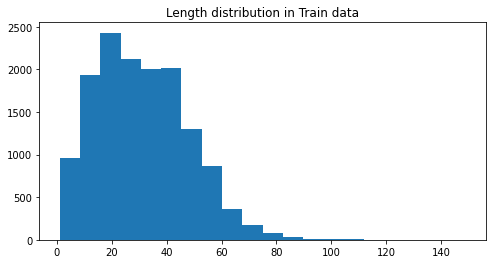

In [18]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [15]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 64 # also can vary 64 /128 (64 лучше)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[224, 26, 27]

In [14]:
batch = next(iter(train_iterator))
#print(batch.char.shape)
print(batch.words.shape)

torch.Size([77, 64])


In [16]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False, num_of_layers=1):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional, num_layers=num_of_layers)
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, int(output_dim))

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        #print(self.embeddings(sent).shape)
        embedded = self.dropout(self.embeddings(sent)) #??????????????

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output) #????????????????????
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM =300 # стандарт не варьируем
HID_DIM = 228 # 128  256 еще
DROPOUT = 0.4 # 0.3 0.2 0.4 0.5 (0.4 - лучший)
BIDIRECTIONAL = True # False True

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM,  OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform(param, -0.08, 0.08)
        
model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


LSTMTagger(
  (embeddings): Embedding(34682, 300)
  (dropout): Dropout(p=0.4, inplace=False)
  (rnn): LSTM(300, 228, bidirectional=True)
  (tag): Linear(in_features=456, out_features=18, bias=True)
)

In [0]:
TAG_PAD_IDX = TAG.vocab.stoi['<pad>'] 
optimizer = optim.Adam(model.parameters(), lr = 0.001) # lr0.001 0.002 0.0005 (lr0.001 лучший)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


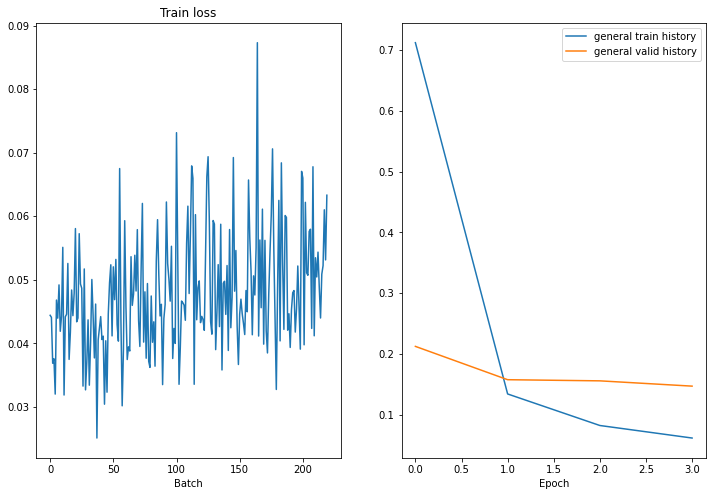

Epoch: 05 | Time: 0m 11s
	Train Loss: 0.048 | Train PPL:   1.049
	 Val. Loss: 0.156 |  Val. PPL:   1.169


In [18]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bi.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [19]:
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 98.743 %
Accuracy valid: 95.663 %
Accuracy test: 95.511 %
F1 score macro train: 89.41103511466349 %
F1 score macro valid: 90.46219805732942 %
F1 score macro test: 89.61095635328013 %
F1 score micro train: 98.74228547780557 %
F1 score micro valid: 95.6626413940691 %
F1 score micro test: 95.51095653496017 %


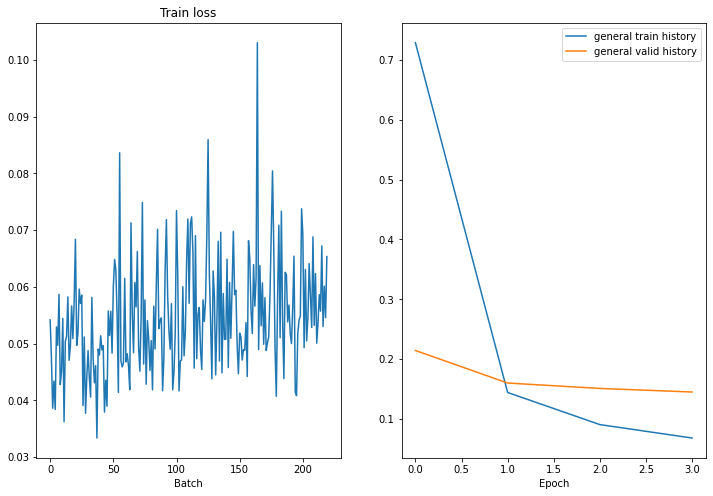

Epoch: 05 | Time: 0m 12s
	Train Loss: 0.055 | Train PPL:   1.056
	 Val. Loss: 0.149 |  Val. PPL:   1.160


In [71]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bi.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [34]:
# no bidirecrional, hid dim 128, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 97.882 %
Accuracy valid: 94.486 %
Accuracy test: 94.487 %
F1 score macro train: 0.8197508233072474 %
F1 score macro valid: 0.8365352448645536 %
F1 score macro test: 0.8447600628694544 %
F1 score micro train: 0.9788221746405887 %
F1 score micro valid: 0.9448563130541119 %
F1 score micro test: 0.9448657278066024 %


In [38]:
# no bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 98.017 %
Accuracy valid: 94.398 %
Accuracy test: 94.333 %
F1 score macro train: 0.8272690934616684 %
F1 score macro valid: 0.8315739456507008 %
F1 score macro test: 0.8406778143869387 %
F1 score micro train: 0.9801694046098206 %
F1 score micro valid: 0.9439773769489452 %
F1 score micro test: 0.9433263013854838 %


In [47]:
# no bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 97.468 %
Accuracy valid: 94.417 %
Accuracy test: 94.325 %
F1 score macro train: 0.7929497126562621 %
F1 score macro valid: 0.7999067163718815 %
F1 score macro test: 0.8064402759518497 %
F1 score micro train: 0.974679273800313 %
F1 score micro valid: 0.9441684500152858 %
F1 score micro test: 0.9432502803276508 %


In [52]:
# no bidirecrional, hid dim 128, dropout 0.2 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 97.774 %
Accuracy valid: 94.354 %
Accuracy test: 94.196 %
F1 score macro train: 0.8140760427440588 %
F1 score macro valid: 0.8048079167385405 %
F1 score macro test: 0.839710496344559 %
F1 score micro train: 0.9777425913597352 %
F1 score micro valid: 0.943537908896362 %
F1 score micro test: 0.9419579223444894 %


# Part II
Bi-directional LSTM

In [58]:
#  bidirecrional, hid dim 128, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 98.685 %
Accuracy valid: 95.617 %
Accuracy test: 95.389 %
F1 score macro train: 0.8871818817593556 %
F1 score macro valid: 0.8904148965401542 %
F1 score macro test: 0.8888503649246609 %
F1 score micro train: 0.9868493261601022 %
F1 score micro valid: 0.9561678385814736 %
F1 score micro test: 0.9538932284242735 %


In [62]:
#  bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 98.798 %
Accuracy valid: 95.754 %
Accuracy test: 95.606 %
F1 score macro train: 0.8986376786382572 %
F1 score macro valid: 0.9097708006358385 %
F1 score macro test: 0.9073312829897473 %
F1 score micro train: 0.9879648955503175 %
F1 score micro valid: 0.9575435646591256 %
F1 score micro test: 0.9560598285725146 %


In [67]:
#  bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 97.945 %
Accuracy valid: 95.294 %
Accuracy test: 95.087 %
F1 score macro train: 0.8246548806125956 %
F1 score macro valid: 0.8280174485790588 %
F1 score macro test: 0.8363068577937514 %
F1 score micro train: 0.9794339384997391 %
F1 score micro valid: 0.952938703760318 %
F1 score micro test: 0.950871391375411 %


In [72]:
#  bidirecrional, hid dim 228, dropout 0.5 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator)

Accuracy train: 98.637 %
Accuracy valid: 95.728 %
Accuracy test: 95.452 %
F1 score macro train: 0.8951574930264775 %
F1 score macro valid: 0.9074091474123871 %
F1 score macro test: 0.8997833649310918 %
F1 score micro train: 0.9863725102110585 %
F1 score micro valid: 0.9572760623662488 %
F1 score micro test: 0.9545204021513959 %


# Part III
biLSTM + Glove

In [14]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = '/content/drive/My Drive/Cup_It/glove-sbwc.i25.vec.gz'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
wordvectors.wv.save_word2vec_format('spanish')
vectors = vocab.Vectors('/content/spanish') # file created by gensim.vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
WORD.vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)

# when defining your network you can then use the method mentioned by blue-phoenox
embedding = nn.Embedding.from_pretrained(torch.FloatTensor(WORD.vocab.vectors))


In [0]:
def _len_sort_key(x):
    return len(x.words)
BATCH_SIZE = 64 #64 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

Нужна ли мне новая модель или достаточно лишь заменить имбедосы????

In [0]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        embedded = self.dropout(self.embedding(text))

        outputs, (hidden, cell) = self.lstm(embedded)
        
        predictions = self.fc(self.dropout(outputs))
        
        
        
        return predictions

In [213]:
INPUT_DIM = len(WORD.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 228 #228
OUTPUT_DIM = len(TAG.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25 #0.4 0.25
PAD_IDX = WORD.vocab.stoi[WORD.pad_token]

model = BiLSTMPOSTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

BiLSTMPOSTagger(
  (embedding): Embedding(34682, 300, padding_idx=1)
  (lstm): LSTM(300, 228, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=456, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [214]:
pretrained_embeddings = WORD.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([34682, 300])


In [215]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4659, -0.3070, -0.1216,  ..., -0.5199, -0.1816,  0.0534],
        ...,
        [-0.4078,  0.2569, -0.1952,  ...,  0.0599, -0.2608, -0.3250],
        [ 0.1107, -0.3002,  0.6310,  ...,  0.5790, -0.0543, -0.2207],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [216]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4659, -0.3070, -0.1216,  ..., -0.5199, -0.1816,  0.0534],
        ...,
        [-0.4078,  0.2569, -0.1952,  ...,  0.0599, -0.2608, -0.3250],
        [ 0.1107, -0.3002,  0.6310,  ...,  0.5790, -0.0543, -0.2207],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [217]:
TAG.vocab.stoi[TAG.pad_token]

0

In [218]:
WORD.vocab.stoi[WORD.pad_token]

1

In [0]:
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

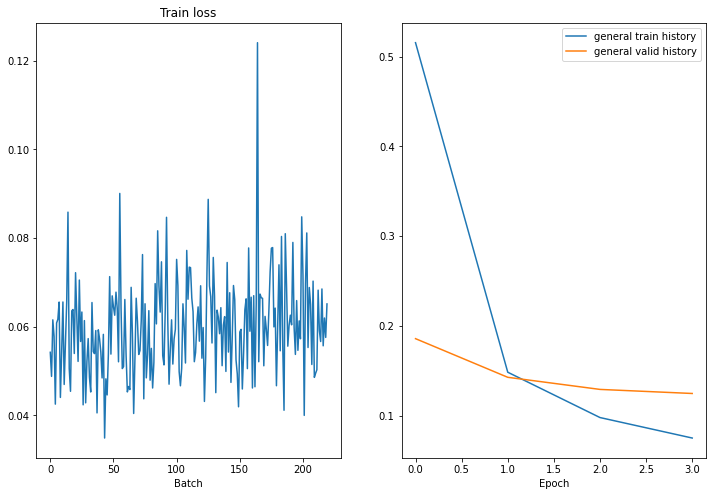

Epoch: 05 | Time: 0m 18s
	Train Loss: 0.060 | Train PPL:   1.062
	 Val. Loss: 0.124 |  Val. PPL:   1.132


In [46]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-glove.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [100]:
#  bidirecrional glove, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.005 %
Accuracy valid: 96.19 %
Accuracy test: 96.043 %
F1 score macro train: 0.874584186574792 %
F1 score macro valid: 0.9023537298209385 %
F1 score macro test: 0.885221950002564 %
F1 score micro train: 0.9800524497543948 %
F1 score micro valid: 0.9619000305716906 %
F1 score micro test: 0.9604310393979132 %


In [32]:
#  bidirecrional glove, hid dim 228, dropout 0.25 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.573 %
Accuracy valid: 96.322 %
Accuracy test: 96.226 %
F1 score macro train: 0.8949753689005799 %
F1 score macro valid: 0.916500882602856 %
F1 score macro test: 0.907801174346715 %
F1 score micro train: 0.985738255033557 %
F1 score micro valid: 0.9632184347294406 %
F1 score micro test: 0.9622555447859057 %


In [39]:
#  bidirecrional glove, hid dim 228, dropout 0.25 lr 0.001 5 epochs batch 128 3 layers
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.583 %
Accuracy valid: 96.274 %
Accuracy test: 96.186 %
F1 score macro train: 0.897699180871563 %
F1 score macro valid: 0.8896186362802241 %
F1 score macro test: 0.894909032274525 %
F1 score micro train: 0.9858327185706317 %
F1 score micro valid: 0.9627407520635891 %
F1 score micro test: 0.9618564342322823 %


In [47]:
#  bidirecrional glove, hid dim 228, dropout 0.25 lr 0.001 5 epochs batch 64 3 layers
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.968 %
Accuracy valid: 96.4 %
Accuracy test: 96.284 %
F1 score macro train: 0.9138784404462532 %
F1 score macro valid: 0.9005859513202965 %
F1 score macro test: 0.9211523010781932 %
F1 score micro train: 0.9896674883494971 %
F1 score micro valid: 0.9640018343014368 %
F1 score micro test: 0.9628447079841116 %


# Let's add char embeddings

In [0]:
import numpy as np

In [13]:
a = np.array([1, 2, 3])
get_s(a)

14

In [19]:
def get_s(k):
  k = np.where(k>0, k*k, 0)
  return(k.sum())

a = np.array(list(map(int,input().split())))
print(get_s(a))



1 2 3
14


In [18]:
a

array(<map object at 0x7fd11311dfd0>, dtype=object)

In [0]:
data_train1 = data_train.copy()
data_val1 = data_val.copy()
data_test1 = data_test.copy()

for i in data_train1:
  i.insert(0, i[0])
  
for i in data_val1:
  i.insert(0, i[0])

for i in data_test1:
  i.insert(0, i[0])


In [0]:
from torchtext.data import Field, NestedField, BucketIterator
import torchtext
#init_token="<bos>", eos_token="<eos>"
# наши поля
WORDS = Field(lower=True)
TAGS = Field(unk_token=None) # все токены нам извсетны
CHARS_NESTING = Field(tokenize=list, init_token="<bos>", eos_token="<eos>", lower=True, fix_length=20)
CHARS = NestedField(CHARS_NESTING)
#CHAR = Field(tokenize=list,  init_token="<bos>", eos_token="<eos>", lower=True)

# создаем примеры
examples_train = []
for chars, words, tags in data_train1:
    examples_train.append(torchtext.data.Example.fromlist([list(chars), list(words), list(tags)], fields=[('chars', CHARS), ('words', WORDS),  ('tags', TAGS)]))

examples_val = []
for chars, words, tags in data_val1:
    examples_val.append(torchtext.data.Example.fromlist([list(chars), list(words), list(tags)], fields=[('chars', CHARS) ,('words', WORDS),  ('tags', TAGS)]))

examples_test = []
for chars, words, tags in data_test1:
    examples_test.append(torchtext.data.Example.fromlist([list(chars), list(words), list(tags)], fields=[('chars', CHARS) , ('words', WORDS), ('tags', TAGS)]))

In [130]:

fields = [('chars', CHARS), ('words', WORDS), ('tags', TAGS)]
train_data = torchtext.data.Dataset(examples_train, fields=fields)
valid_data = torchtext.data.Dataset(examples_val, fields=fields)
test_data = torchtext.data.Dataset(examples_test, fields=fields)


print(train_data.fields)
print(len(train_data))
print(vars(train_data[1]))

{'chars': <torchtext.data.field.NestedField object at 0x7fe2f7d4a588>, 'words': <torchtext.data.field.Field object at 0x7fe2f7d4a358>, 'tags': <torchtext.data.field.Field object at 0x7fe2f7d4a2e8>}
14305
{'chars': [['s', 'o', 'b', 'r', 'e'], ['l', 'a'], ['o', 'f', 'e', 'r', 't', 'a'], ['d', 'e'], ['i', 'n', 't', 'e', 'r', 'c', 'o', 'n', 'e', 'x', 'i', 'ó', 'n'], ['c', 'o', 'n'], ['t', 'e', 'l', 'e', 'f', 'ó', 'n', 'i', 'c', 'a'], ['d', 'e'], ['o', 't', 'r', 'o', 's'], ['o', 'p', 'e', 'r', 'a', 'd', 'o', 'r', 'e', 's'], ['q', 'u', 'e'], ['a', 'c', 'a', 'b', 'a'], ['d', 'e'], ['a', 'p', 'r', 'o', 'b', 'a', 'r'], ['l', 'a'], ['c', 'm', 't'], [','], ['v', 'á', 'z', 'q', 'u', 'e', 'z'], ['q', 'u', 'i', 'n', 't', 'a', 'n', 'a'], ['d', 'i', 'j', 'o'], ['q', 'u', 'e'], ['p', 'a', 'r', 'a'], ['d', 'e', 's', 'a', 'r', 'r', 'o', 'l', 'l', 'a', 'r'], ['l', 'a'], ['h', 'a', 'n'], ['e', 's', 'c', 'u', 'c', 'h', 'a', 'd', 'o'], ['a'], ['l', 'o', 's'], ['o', 'p', 'e', 'r', 'a', 'd', 'o', 'r', 'e', 's'

In [131]:
WORDS.build_vocab(train_data.words) #val.word, test.word
CHARS.build_vocab(train_data.chars) #, val.char, test.char
TAGS.build_vocab(train_data.tags)

#print(CHAR.vocab.freqs)

BATCH_SIZE = 128 # 64
def _len_sort_key(x):
    return len(x.words)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

batch = next(iter(train_iterator))

print("words", batch.words)
print("chars", batch.chars)
print("tags", batch.tags)

words tensor([[ 153,    4,    5,  ..., 2402,    5,   52],
        [ 835,  263,  364,  ...,   27, 1124, 4246],
        [   3,  437,   25,  ...,   65, 8929,   69],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')
chars tensor([[[ 2,  6, 14,  ...,  1,  1,  1],
         [ 2,  4,  8,  ...,  1,  1,  1],
         [ 2, 18,  3,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 2, 11,  5,  ...,  1,  1,  1],
         [ 2, 13,  6,  ...,  1,  1,  1],
         [ 2,  4,  7,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 2,  4, 11,  ...,  1,  1,  1],
         [ 2,  6, 19,  ...,  1,  1,  1],
         [ 2,  4,  7,  ...,  1,  1,  1]

In [0]:
WORDS.vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)

In [0]:
embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(WORDS.vocab.vectors))


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class WordCharCNNEmbeddingLSTM(nn.Module):

    def __init__(self,
                 hid_dim,
                 output_dim,
                 word_num_embedding,
                 char_num_embedding,
                 padding_size=2,
                 
                 word_embedding_dim=300,
                 word_padding_idx=1,
                
                 char_embedding_dim=228,
                 char_padding_idx=1,
                 dropout=0.25,
                 kernel_size=3,
                 out_channels=228, #228,
                 pretrained_word_embedding=None,
                 bidirectional=True):
      
        super().__init__()
        self.char_embedding = nn.Embedding(
            char_num_embedding, char_embedding_dim, char_padding_idx)
        self._init_char_embedding(char_padding_idx)
        self.conv_embedding = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(kernel_size, char_embedding_dim)))
        self.word_embedding = nn.Embedding(
            word_num_embedding, word_embedding_dim, word_padding_idx)
        if isinstance(pretrained_word_embedding, torch.Tensor):
            self.word_embedding.weight.data.copy_(pretrained_word_embedding)
            # Freeze the embedding layer when using pretrained word
            # embedding
            self.word_embedding.weight.requires_grad = False
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(word_embedding_dim+out_channels, hid_dim, bidirectional=bidirectional)
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, int(output_dim))
 

    def _init_char_embedding(self, padding_idx):

        nn.init.xavier_normal_(self.char_embedding.weight)
        # Reinitialize vectors at padding_idx to have 0 value
        self.char_embedding.weight.data[padding_idx].uniform_(0, 0)

    def forward(self, X, X_word):
        word_size = X.size(1)
        char_embeddings = []
        # We have X in dimension of [batch, words, chars]. To use
        # batch calculation we need to loop over all words and
        # calculate the embedding
        for i in range(word_size):
            # Convert the embedding size from [batch, chars]
            # into [batch, 1, chars]. 1 is our channel for
            # convolution layer later
            x = X[:, i, :].unsqueeze(1)
            # Apply embedding for every characters on batch.
            # The dimension now will be [batch, 1, chars, emb]
            char_embedding = self.char_embedding(x)
            # Apply char embedding with dropout and convolution
            # layers so the dim now will be [batch, conv_size, new_height, 1]
            char_embedding = self.conv_embedding(char_embedding)
            # Remove the last dimension with size 1
            char_embedding = char_embedding.squeeze(-1)
            # Apply pooling layer so the new dim will be [batch, conv_size, 1]
            char_embedding = F.max_pool2d(
                char_embedding,
                kernel_size=(1, char_embedding.size(2)),
                stride=1)
            # Transpose it before we put it into array for later concatenation
            char_embeddings.append(char_embedding.transpose(1, 2))

        # Concatenate the whole char embeddings
        final_char_embedding = torch.cat(char_embeddings, dim=1)
        word_embedding =  self.word_embedding(X_word)
        #print(final_char_embedding.shape,  word_embedding.shape)
        # Combine both character and word embeddings
        result = torch.cat([final_char_embedding.permute(1,0,2), word_embedding], 2)
        
        output, _ = self.rnn(result)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output) #
        return prediction


In [0]:
OUTPUT_DIM = len(TAGS.vocab)
 # стандарт не варьируем
HID_DIM = 228
model = WordCharCNNEmbeddingLSTM(HID_DIM, len(TAGS.vocab), len(WORDS.vocab), len(CHARS.vocab), pretrained_word_embedding=embeddings).to(device)


In [0]:
TAG_PAD_IDX = TAGS.vocab.stoi['<pad>'] 
optimizer = optim.Adam(model.parameters(), lr = 0.001) # lr0.001 0.002 0.0005 (lr0.001 лучший)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


In [39]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform(param, -0.08, 0.08)
        
model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


WordCharCNNEmbeddingLSTM(
  (char_embedding): Embedding(81, 228, padding_idx=1)
  (conv_embedding): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Conv2d(1, 228, kernel_size=(3, 228), stride=(1, 1))
  )
  (word_embedding): Embedding(34682, 300, padding_idx=1)
  (dropout): Dropout(p=0.25, inplace=False)
  (rnn): LSTM(528, 228, bidirectional=True)
  (tag): Linear(in_features=456, out_features=18, bias=True)
)

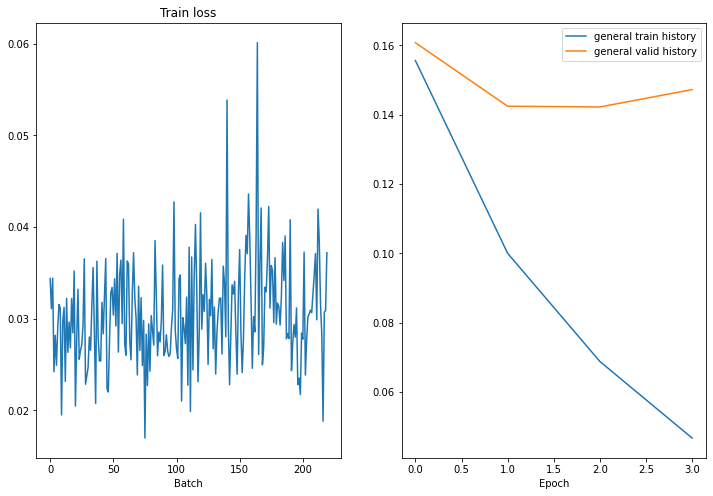

Epoch: 05 | Time: 1m 4s
	Train Loss: 0.031 | Train PPL:   1.031
	 Val. Loss: 0.151 |  Val. PPL:   1.163


In [42]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1 #поменять??

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, is_char=True)
    valid_loss = evaluate(model, valid_iterator, criterion, is_char=True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bi.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [49]:
# char without pretrained embeddings
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=True)

Accuracy train: 98.715 %
Accuracy valid: 95.751 %
Accuracy test: 95.68 %
F1 score macro train: 90.20859535622259 %
F1 score macro valid: 92.30365595066256 %
F1 score macro test: 92.35933964733228 %
F1 score micro train: 98.71439624305019 %
F1 score micro valid: 95.75053500458576 %
F1 score micro test: 95.68010338863864 %


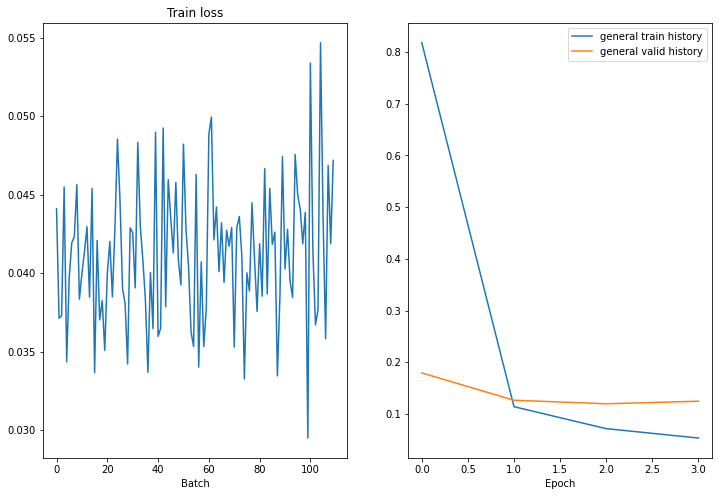

Epoch: 05 | Time: 0m 55s
	Train Loss: 0.041 | Train PPL:   1.042
	 Val. Loss: 0.132 |  Val. PPL:   1.141


In [40]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1 #поменять??

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, is_char=True)
    valid_loss = evaluate(model, valid_iterator, criterion, is_char=True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bi.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [41]:
#gloves drop 0.25 char 228. batch_size 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=True)

Accuracy train: 98.426 %
Accuracy valid: 96.272 %
Accuracy test: 96.205 %
F1 score macro train: 88.3545771622451 %
F1 score macro valid: 92.122273586368 %
F1 score macro test: 90.05457462578744 %
F1 score micro train: 98.42560771542185 %
F1 score micro valid: 96.2721644756955 %
F1 score micro test: 96.20464868768649 %


In [34]:
#gloves drop 0.5 char 228 batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=True)

Accuracy train: 98.722 %
Accuracy valid: 96.253 %
Accuracy test: 96.169 %
F1 score macro train: 89.9476227775819 %
F1 score macro valid: 92.22429188357356 %
F1 score macro test: 91.7102380615702 %
F1 score micro train: 98.72181837810605 %
F1 score micro valid: 96.25305716906145 %
F1 score micro test: 96.16853868521581 %


In [28]:
#gloves drop 0.5 char 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=True)

Accuracy train: 98.725 %
Accuracy valid: 96.156 %
Accuracy test: 95.99 %
F1 score macro train: 89.97170481442815 %
F1 score macro valid: 91.93230048531686 %
F1 score macro test: 91.17310362068794 %
F1 score micro train: 98.72519207585871 %
F1 score micro valid: 96.15560990522776 %
F1 score micro test: 95.98988919930821 %


# CRF

In [0]:
def acc(model, iterator, TAG_PAD_IDX=1, is_char=False):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            if is_char:
              words = batch.words
              chars = batch.chars ###
              tags = batch.tags#
              output = model.predict(chars, words)
            else:
              words = batch.words ###
              tags = batch.tags###

              output = model.predict(words) ###
            
            #output = [sent len, batch size, output dim]
            #output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices ###
            tags = tags.view(-1)
            output =output.reshape(-1)
           
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()
            

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != TAG_PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == TAG_PAD_IDX).sum()
            
    return round(true_pred / num_pred * 100, 3)


def get_pr(model, iterator, is_char):
  model.eval()
  preds = []
  tags_given = []
  with torch.no_grad():
        for i, batch in enumerate(iterator):
            if is_char:
              words = batch.words
              chars = batch.chars ###
              tags = batch.tags#
              output = model.predict(chars, words)
            else:
              words = batch.words ###
              tags = batch.tags###

              output = model.predict(words) ###
            
            #output = [sent len, batch size, output dim]
            output = output.reshape(-1) ###
            tags = tags.view(-1)

            #output = [sent len, batch size]
            predict_tags = output.squeeze().cpu().numpy()
            
            true_tags = tags.cpu().numpy()
            args = np.where(true_tags!=TAG_PAD_IDX)[0]

            predict_tags = predict_tags[args]
            true_tags = true_tags[args]

            if i==0:
              preds = predict_tags
              tags_given = true_tags
            else:
              preds = np.append(preds, predict_tags)
              #print(preds.shape)
              tags_given = np.append(tags_given, true_tags)
              #print(tags.shape)
  return preds, tags_given


def get_f1(model, iterator, is_char=False):
  from sklearn.metrics import f1_score
  preds, tags = get_preds(model, iterator, is_char)
  f1_score_macro = f1_score(tags, preds, average='macro') * 100
  f1_score_micro = f1_score(tags, preds, average='micro') * 100
  return f1_score_macro, f1_score_micro



def print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=False):
  model.load_state_dict(torch.load(name))
  print("Accuracy train:", acc(model, train_iterator,is_char=is_char), '%')
  print("Accuracy valid:", acc(model, valid_iterator, is_char=is_char), '%')
  print("Accuracy test:", acc(model, test_iterator, is_char=is_char), '%')
  macro_train, micro_train = get_f1(model, train_iterator, is_char=is_char)
  macro_valid, micro_valid = get_f1(model, valid_iterator, is_char=is_char)
  macro_test, micro_test = get_f1(model, test_iterator, is_char=is_char)
  print("F1 score macro train:", macro_train, "%")
  print("F1 score macro valid:", macro_valid, "%")
  print("F1 score macro test:", macro_test, "%")
  print("F1 score micro train:", micro_train, "%")
  print("F1 score micro valid:", micro_valid, "%")
  print("F1 score micro test:", micro_test, "%")


In [0]:
class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences):
        embedded = self.embedding(sentences)
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, sentences, labels):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        return -self.crf(scores, labels)
            
    def predict(self, sentences):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        return torch.Tensor(np.array(self.crf.decode(scores)).T)

In [0]:
n_tokens_train = 0
n_sentences_train = 0
for ex in examples_train:
      n_tokens_train += len(ex.words) + 2
      n_sentences_train += 1
n_tokens_valid = 0       
for ex in examples_val:
      n_tokens_valid += len(ex.words)

n_tokens_val = 0
n_sentences_val = 0
for ex in examples_val:
      n_tokens_val += len(ex.words) + 2
      n_sentences_val += 1
n_tokens_val = 0       
for ex in examples_val:
      n_tokens_val += len(ex.words)


n_batches = np.ceil(n_sentences_train / 64)
n_batches_val = np.ceil(n_sentences_val/64)
mean_n_tokens = n_tokens_train / n_batches
mean_v_tokens = n_tokens_val / n_batches

In [46]:
!pip install pytorch-crf

In [0]:
from torchcrf import CRF

In [152]:
model = RNNCRFTagger(WORDS, TAGS, 300, 228, update_pretrained=False)
model.to(device)

RNNCRFTagger(
  (embedding): Embedding(34682, 300)
  (rnn): GRU(300, 228, bidirectional=True)
  (top_layer): Linear(in_features=456, out_features=18, bias=True)
  (crf): CRF(num_tags=18)
)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [0]:
from collections import defaultdict,Counter

In [154]:
n_labels = len(TAGS.vocab)
history = defaultdict(list)   

best_valid_loss = float('inf')  

n_epochs = 5
        
for i in range(n_epochs):

    

    loss_sum = 0

    
    for j, batch in enumerate(train_iterator): 
            model.train()
                # Compute the output and loss.
            loss = model(batch.words, batch.tags) / mean_n_tokens
                
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

    train_loss = loss_sum / n_batches
    history['train_loss'].append(train_loss)

            # Evaluate on the validation set.
            # if i % 1 == 0:
            #     stats = defaultdict(Counter)


    loss_val = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_iterator:
                        # Predict the model's output on a batch.
            #predicted = model.predict(batch.word)    
            loss = model(batch.words, batch.tags) / mean_v_tokens
            loss_val += loss.item()
    
    val_loss = loss_val / n_batches
    history['val_loss'].append(val_loss)
    train_loss, valid_loss = history['train_loss'][i], history['val_loss'][i]

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-crf.pt')
        
    print(f'Epoch: {i+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 0.336 | Train PPL:   1.399
	 Val. Loss: 0.177 |  Val. PPL:   1.194
Epoch: 02
	Train Loss: 0.112 | Train PPL:   1.118
	 Val. Loss: 0.142 |  Val. PPL:   1.153
Epoch: 03
	Train Loss: 0.072 | Train PPL:   1.075
	 Val. Loss: 0.142 |  Val. PPL:   1.152
Epoch: 04
	Train Loss: 0.059 | Train PPL:   1.061
	 Val. Loss: 0.147 |  Val. PPL:   1.159
Epoch: 05
	Train Loss: 0.049 | Train PPL:   1.051
	 Val. Loss: 0.152 |  Val. PPL:   1.164


In [155]:
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-crf.pt', is_char=False)

Accuracy train: 99.583 %
Accuracy valid: 96.476 %
Accuracy test: 96.266 %
F1 score macro train: 94.93228817309229 %
F1 score macro valid: 88.71040608922561 %
F1 score macro test: 91.47661516414351 %
F1 score micro train: 98.46834122028896 %
F1 score micro valid: 95.4639254050749 %
F1 score micro test: 95.4900507440561 %


In [62]:
acc(model, test_iterator, TAG_PAD_IDX=1, is_char=False)

96.185

In [64]:
get_f1_score(model, test_iterator, is_char=False)

(91.64653986781828, 95.41783073911473)

In [0]:
class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, char_num_embedding,
                 padding_size=2 ,char_embedding_dim=228,
                 char_padding_idx=1,
                 dropout=0.25,
                 kernel_size=3,
                 out_channels=228, update_pretrained=False):
      
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)  


        self.char_embedding = nn.Embedding(
            char_num_embedding, char_embedding_dim, char_padding_idx)
        self._init_char_embedding(char_padding_idx)
        self.conv_embedding = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(kernel_size, char_embedding_dim)))     
        
        self.word_embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.word_embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.dropout = nn.Dropout(p=dropout)

        self.rnn = nn.GRU(input_size=emb_dim+out_channels, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
    
    def _init_char_embedding(self, padding_idx):
        """Initialize the weight of character embedding with xavier
        and reinitalize the padding vectors to zero
        """

        nn.init.xavier_normal_(self.char_embedding.weight)
        # Reinitialize vectors at padding_idx to have 0 value
        self.char_embedding.weight.data[padding_idx].uniform_(0, 0)
        
    def compute_outputs(self, chars, sentences):
        word_size = chars.size(1)
        char_embeddings = []
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        for i in range(word_size):
            # Convert the embedding size from [batch, chars]
            # into [batch, 1, chars]. 1 is our channel for
            # convolution layer later
            x = chars[:, i, :].unsqueeze(1)
            # Apply embedding for every characters on batch.
            # The dimension now will be [batch, 1, chars, emb]
            char_embedding = self.char_embedding(x)
            # Apply char embedding with dropout and convolution
            # layers so the dim now will be [batch, conv_size, new_height, 1]
            char_embedding = self.conv_embedding(char_embedding)
            # Remove the last dimension with size 1
            char_embedding = char_embedding.squeeze(-1)
            # Apply pooling layer so the new dim will be [batch, conv_size, 1]
            char_embedding = F.max_pool2d(
                char_embedding,
                kernel_size=(1, char_embedding.size(2)),
                stride=1)
            # Transpose it before we put it into array for later concatenation
            char_embeddings.append(char_embedding.transpose(1, 2))

        # Concatenate the whole char embeddings
        final_char_embedding = torch.cat(char_embeddings, dim=1)
        word_embedding =  self.word_embedding(sentences)
        result = torch.cat([final_char_embedding.permute(1,0,2), word_embedding], 2)
        
        rnn_out, _ = self.rnn(result)
        out = self.top_layer(rnn_out)
        #print(out.shape)
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, chars, sentences, labels):

        
        scores = self.compute_outputs(chars, sentences)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        return -self.crf(scores, labels)
            
    def predict(self, chars, sentences):
        # Compute the emission scores, as above.
        

        #result = result.permute(0, 2, 1)

        scores = self.compute_outputs(chars, sentences)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        return torch.Tensor(np.array(self.crf.decode(scores)).T)

In [0]:
model = RNNCRFTagger(WORDS, TAGS, 300, 228, len(CHARS.vocab), update_pretrained=False)
model.to(device)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [134]:
n_labels = len(TAGS.vocab)
history = defaultdict(list)   

best_valid_loss = float('inf')  

n_epochs = 5
        
for i in range(n_epochs):

    

    loss_sum = 0

    
    for j, batch in enumerate(train_iterator): 
            model.train()
                # Compute the output and loss.
            loss = model(batch.chars, batch.words, batch.tags) / mean_n_tokens
                
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

    train_loss = loss_sum / n_batches
    history['train_loss'].append(train_loss)

            # Evaluate on the validation set.
            # if i % 1 == 0:
            #     stats = defaultdict(Counter)


    loss_val = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_iterator:
                        # Predict the model's output on a batch.
            #predicted = model.predict(batch.word)    
            loss = model(batch.chars, batch.words, batch.tags) / mean_v_tokens
            loss_val += loss.item()
    
    val_loss = loss_val / n_batches
    history['val_loss'].append(val_loss)
    train_loss, valid_loss = history['train_loss'][i], history['val_loss'][i]

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-crf.pt')
        
    print(f'Epoch: {i+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 0.276 | Train PPL:   1.318
	 Val. Loss: 0.145 |  Val. PPL:   1.156
Epoch: 02
	Train Loss: 0.089 | Train PPL:   1.093
	 Val. Loss: 0.112 |  Val. PPL:   1.118
Epoch: 03
	Train Loss: 0.068 | Train PPL:   1.070
	 Val. Loss: 0.107 |  Val. PPL:   1.113
Epoch: 04
	Train Loss: 0.058 | Train PPL:   1.060
	 Val. Loss: 0.106 |  Val. PPL:   1.112
Epoch: 05
	Train Loss: 0.051 | Train PPL:   1.052
	 Val. Loss: 0.105 |  Val. PPL:   1.111


In [149]:
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-crf.pt', is_char=True)

Accuracy train: 99.668 %
Accuracy valid: 97.452 %
Accuracy test: 97.261 %
F1 score macro train: 98.03968852865013 %
F1 score macro valid: 91.8985469489757 %
F1 score macro test: 93.01091446229864 %
F1 score micro train: 98.78816776724184 %
F1 score micro valid: 96.54348822989911 %
F1 score micro test: 96.57335081817664 %


# Part III
BERT

In [15]:
! pip install transformers

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 890kB 9.4MB/s 
     |████████████████████████████████| 1.0MB 14.7MB/s 
     |████████████████████████████████| 3.8MB 27.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7514cb42ea7b87980d8f4cfa2d6b9f1c72391849ada6073a905fd957ccf16bed
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets

from transformers import BertTokenizer, BertModel

import numpy as np

import time
import random
import functools
import transformers

## Models to try:

In [0]:
# 'bert-base-multilingual-uncased' 'bert-base-multilingual-cased'

In [0]:
#'dccuchile/bert-base-spanish-wwm-uncased' 'dccuchile/bert-base-spanish-wwm-cased'

In [17]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
tokenizer.tokenize('Este hombre es muy guapo')

['Este', 'hombre', 'es', 'muy', 'guapo']

In [18]:
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, pad_token, unk_token)

[CLS] [PAD] [UNK]


In [19]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

4 1 3


In [20]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-cased']

print(max_input_length)

512


In [0]:
def cut_and_convert_to_id(tokens, tokenizer, max_input_length):
    tokens = tokens[:max_input_length-1]
    tokens = tokenizer.convert_tokens_to_ids(tokens)
    return tokens

In [0]:
def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

In [0]:
text_preprocessor = functools.partial(cut_and_convert_to_id,
                                      tokenizer = tokenizer,
                                      max_input_length = max_input_length)

tag_preprocessor = functools.partial(cut_to_max_length,
                                     max_input_length = max_input_length)

In [26]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORDS = data.Field(use_vocab = False,
                  lower = True,
                  preprocessing = text_preprocessor,
                  init_token = init_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

TAGS = data.Field(unk_token = None,
                     init_token = '<pad>',
                     preprocessing = tag_preprocessor) # все токены нам извсетны

# создаем примеры
examples_train = []
for words, tags in data_train:
    examples_train.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORDS), ('tags', TAGS)]))

examples_val = []
for words, tags in data_val:
    examples_val.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORDS), ('tags', TAGS)]))

examples_test = []
for words, tags in data_test:
    examples_test.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORDS), ('tags', TAGS)]))

train_data =torchtext.data.Dataset(examples_train, fields=[('words', WORDS), ('tags', TAGS)])
valid_data = torchtext.data.Dataset(examples_val, fields=[('words', WORDS), ('tags', TAGS)])
test_data = torchtext.data.Dataset(examples_test, fields=[('words', WORDS), ('tags', TAGS)])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 14305
Number of validation examples: 1654
Number of testing examples: 1721


In [230]:
print(vars(train_data.examples[0]))

{'words': [1040, 3599, 1072, 6322, 24552, 1008, 1089, 3, 1062, 12048, 29533, 1008, 10563, 1359, 16014, 1008, 1089, 3, 1051, 2074, 2160, 1038, 3, 1030, 4220, 1184, 1499, 1200, 5867, 1040, 3209, 1013, 1030, 1924, 1008, 1065, 5615, 1008, 18651, 1013, 1759, 12072, 1009], 'tags': ['DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PRON', 'VERB', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'DET', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'PUNCT']}


In [27]:
WORDS.build_vocab(train_data)

TAGS.build_vocab(train_data)

print(TAGS.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fa9819961e0>, {'<pad>': 0, 'NOUN': 1, 'ADP': 2, 'DET': 3, 'PUNCT': 4, 'VERB': 5, 'PROPN': 6, 'ADJ': 7, 'PRON': 8, 'ADV': 9, 'AUX': 10, 'CCONJ': 11, 'SCONJ': 12, 'NUM': 13, 'SYM': 14, 'PART': 15, 'INTJ': 16, 'X': 17})


In [0]:
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key)

In [0]:
class BERTPoSTagger(nn.Module):
    def __init__(self,
                 bert,
                 output_dim, 
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
  
        #text = [sent len, batch size]
    
        text = text.permute(1, 0)
        
        #text = [batch size, sent len]
        
        embedded = self.dropout(self.bert(text)[0])
        
        #embedded = [batch size, seq len, emb dim]
                
        embedded = embedded.permute(1, 0, 2)
                    
        #embedded = [sent len, batch size, emb dim]
        
        predictions = self.fc(self.dropout(embedded))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

In [30]:
bert = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

In [0]:
OUTPUT_DIM = len(TAGS.vocab)
DROPOUT = 0.25

model = BERTPoSTagger(bert,
                      OUTPUT_DIM, 
                      DROPOUT)

In [0]:
epochs = 10
lr = 1e-5 #5e-5
warmup_steps = len(train_iterator) // 2
t_total = len(train_iterator) * epochs
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters()], "weight_decay": 0.0},
]

# <YOUR CODE>
criterion = torch.nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
)
model.to(device)
criterion = criterion.to(device)


In [0]:
LEARNING_RATE = 5e-5 #5e-5   5e-4  5e-8  1e-4 и dropout 4??? попробовать

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
TAG_PAD_IDX = TAGS.vocab.stoi[TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

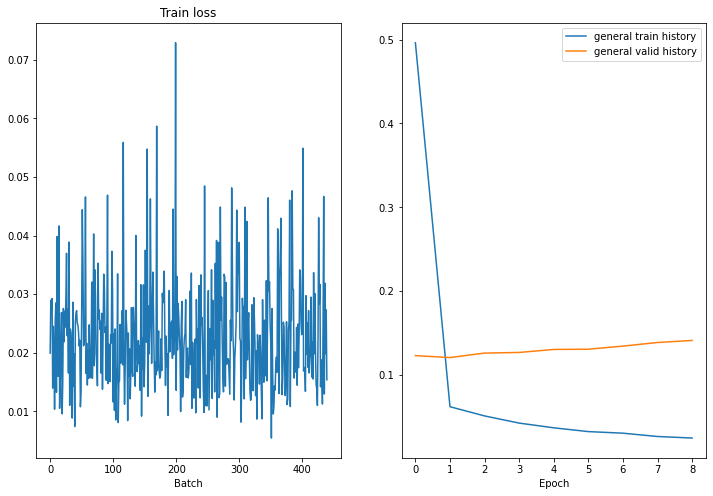

Epoch: 10 | Time: 1m 58s
	Train Loss: 0.023 | Train PPL:   1.024
	 Val. Loss: 0.143 |  Val. PPL:   1.153


In [46]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 10 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, scheduler=scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bert_mull.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [47]:
#  beto cased ???
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_mull.pt') #'best-val-model-bert_mull.pt'

Accuracy train: 98.968 %
Accuracy valid: 97.151 %
Accuracy test: 97.039 %
F1 score macro train: 89.00040895967987 %
F1 score macro valid: 89.19791014965885 %
F1 score macro test: 90.38402999968662 %
F1 score micro train: 98.96135091854545 %
F1 score micro valid: 97.15110058086212 %
F1 score micro test: 97.03897979740388 %


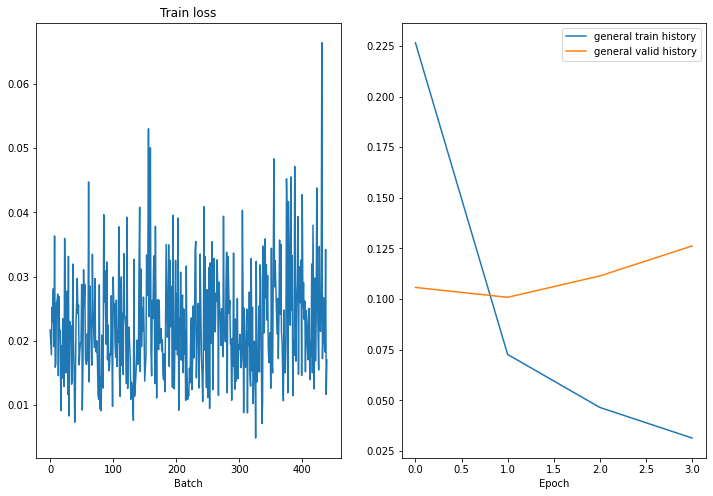

Epoch: 05 | Time: 2m 13s
	Train Loss: 0.023 | Train PPL:   1.023
	 Val. Loss: 0.135 |  Val. PPL:   1.145


In [257]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bert_mull.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [258]:
#  beto cased ???
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert.pt') #'best-val-model-bert_mull.pt'

Accuracy train: 98.784 %
Accuracy valid: 97.189 %
Accuracy test: 97.096 %
F1 score macro train: 0.9072026171327909 %
F1 score macro valid: 0.9197493099826978 %
F1 score macro test: 0.9222696656561868 %
F1 score micro train: 0.9877849650035087 %
F1 score micro valid: 0.9718931519413023 %
F1 score micro test: 0.9709599559077865 %


In [83]:
#  bert beto uncased
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert.pt') 

Accuracy train: 98.823 %
Accuracy valid: 97.059 %
Accuracy test: 97.058 %
F1 score macro train: 0.9076109660772128 %
F1 score macro valid: 0.919548907704057 %
F1 score macro test: 0.9240669855918578 %
F1 score micro train: 0.9882347913705309 %
F1 score micro valid: 0.9705938550901865 %
F1 score micro test: 0.9705798506186214 %


In [98]:
#  bert beto cased
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert.pt') #'best-val-model-bi.pt'

Accuracy train: 98.852 %
Accuracy valid: 97.285 %
Accuracy test: 97.088 %
F1 score macro train: 0.9107609187870733 %
F1 score macro valid: 0.9217471409974984 %
F1 score macro test: 0.9299205264905903 %
F1 score micro train: 0.9885024380589092 %
F1 score micro valid: 0.9728485172730051 %
F1 score micro test: 0.9708839348499534 %


In [112]:
#  bert multilingual cased
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_mul.pt') #'best-val-model-bi.pt'

Accuracy train: 97.122 %
Accuracy valid: 95.076 %
Accuracy test: 94.983 %
F1 score macro train: 0.8820739268827023 %
F1 score macro valid: 0.8895137228576704 %
F1 score macro test: 0.9087580154983054 %
F1 score micro train: 0.9712988286521402 %
F1 score micro valid: 0.9507604708040355 %
F1 score micro test: 0.949826101830207 %


In [129]:
#  bert multilingual uncased
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_mul.pt') #'best-val-model-bi.pt'

Accuracy train: 96.154 %
Accuracy valid: 93.93 %
Accuracy test: 93.956 %
F1 score macro train: 0.8692216848082964 %
F1 score macro valid: 0.8789018707747094 %
F1 score macro test: 0.9058352515031716 %
F1 score micro train: 0.9614813681918779 %
F1 score micro valid: 0.9392960868236013 %
F1 score micro test: 0.9395632590227494 %
